## Analysis of BayWheels Public Bikeshare Data on Google Cloud Platform

The analysis is performed with SQL on BigQuery and AI Platform to answer the following questions regarding [BayWheels](https://www.lyft.com/bikes/bay-wheels/pricing):

- What are the 5 most popular trips that we would call "commuter trips"?
- What are your recommendations for offers?

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Initial EDA

#### Feature Selection

First, selected features of the `bikeshare_trips` data was extracted, modified as new fields, and stored as a view named `initial`. Obvious data cleaning was also carried out. On the pricing page of the Lyft Bay Wheels website, it mentions that single rides are charged \$ 2 for one ride up to 30 minutes. To filter data entry errors, `duration_sec > 0` was used.

In [11]:
%%bigquery df

SELECT trip_id, duration_sec,
       ROUND(duration_sec / 60.0) AS duration_minutes,
       ROUND(duration_sec / 3600.0) AS duration_hours,
       start_date, end_date,
       EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
           ELSE "Weekday"
           END AS dow_weekday,
       EXTRACT(HOUR FROM start_date) AS start_hour,
       start_station_name, end_station_name,
       bike_number, subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE duration_sec > 0 and end_date > start_date
ORDER BY duration_minutes DESC
limit 10

In [12]:
df

,trip_id,duration_sec,duration_minutes,duration_hours,start_date,end_date,dow_int,dow_weekday,start_hour,start_station_name,end_station_name,bike_number,subscriber_type
0,568474,17270400,287840.0,4797.0,2014-12-06 21:59:00+00:00,2015-06-24 20:18:00+00:00,7,Weekend,21,South Van Ness at Market,2nd at Folsom,535,Customer
1,825850,2137000,35617.0,594.0,2015-06-28 21:50:00+00:00,2015-07-23 15:27:00+00:00,1,Weekend,21,Market at Sansome,Yerba Buena Center of the Arts (3rd @ Howard),466,Customer
2,750192,1852590,30877.0,515.0,2015-05-02 06:17:00+00:00,2015-05-23 16:53:00+00:00,7,Weekend,6,San Antonio Shopping Center,Castro Street and El Camino Real,680,Subscriber
3,841176,1133540,18892.0,315.0,2015-07-10 10:35:00+00:00,2015-07-23 13:27:00+00:00,6,Weekday,10,University and Emerson,University and Emerson,262,Customer
4,111309,722236,12037.0,201.0,2013-11-30 13:29:00+00:00,2013-12-08 22:06:00+00:00,7,Weekend,13,University and Emerson,University and Emerson,247,Customer
5,522337,720454,12008.0,200.0,2014-10-30 08:29:00+00:00,2014-11-07 15:36:00+00:00,5,Weekday,8,Redwood City Caltrain Station,Stanford in Redwood City,692,Customer
6,323594,716480,11941.0,199.0,2014-06-13 16:57:00+00:00,2014-06-21 23:59:00+00:00,6,Weekday,16,Harry Bridges Plaza (Ferry Building),Civic Center BART (7th at Market),633,Subscriber
7,361321,715339,11922.0,199.0,2014-07-13 05:50:00+00:00,2014-07-21 12:32:00+00:00,1,Weekend,5,Arena Green / SAP Center,Adobe on Almaden,251,Customer
8,774999,688899,11482.0,191.0,2015-05-20 15:27:00+00:00,2015-05-28 14:49:00+00:00,4,Weekday,15,Palo Alto Caltrain Station,California Ave Caltrain Station,230,Customer
9,635260,655939,10932.0,182.0,2015-02-08 03:05:00+00:00,2015-02-15 17:17:00+00:00,1,Weekend,3,San Jose Civic Center,SJSU 4th at San Carlos,132,Customer


Based on the query result for part 1 question 1, we have found that the average ride duration for a customer is 538% longer than that by the subscriber. However, this result is dubious, as we can seen from the our initial query, the longer rides are mostly made by customers, and are unrepresentative of regular rides. The rides ranges from a few days to a ride longer than 6 months. Clearly, rides longer than a single day represent trips when the user has not returned the bikes to any stations.

In the following query we attempt to find a duration of usage that is representative of usage by most users, since averaging duration would lead to significant skew by longer usetime. The query result shows that the number of trips above 12 to 13 hours of usage cease to represent a countable portion of the data set (rounded to zero).

In [13]:
%%bigquery

SELECT subscriber_type,
       SUM(CASE WHEN duration_hours <= 11 THEN 1 ELSE 0 END) / COUNT(trip_id) as Lesser_11,
       SUM(CASE WHEN duration_hours > 11 THEN 1 ELSE 0 END)  / COUNT(trip_id) as Greater_11,
       SUM(CASE WHEN duration_hours <= 12 THEN 1 ELSE 0 END) / COUNT(trip_id) as Lesser_12,
       SUM(CASE WHEN duration_hours > 12 THEN 1 ELSE 0 END)  / COUNT(trip_id) as Greater_12,
       SUM(CASE WHEN duration_hours <= 13 THEN 1 ELSE 0 END) / COUNT(trip_id) as Lesser_13,
       SUM(CASE WHEN duration_hours > 13 THEN 1 ELSE 0 END)  / COUNT(trip_id) as Greater_13,
       SUM(CASE WHEN duration_hours <= 14 THEN 1 ELSE 0 END) / COUNT(trip_id) as Lesser_14,
       SUM(CASE WHEN duration_hours > 14 THEN 1 ELSE 0 END)  / COUNT(trip_id) as Greater_14
FROM `practical-net-263804.bike_trip_data.initial`
GROUP BY subscriber_type

,subscriber_type,Lesser_11,Greater_11,Lesser_12,Greater_12,Lesser_13,Greater_13,Lesser_14,Greater_14
0,Customer,0.999079,0.000921,0.999750,0.000250,1.0,0.0,1.0,0.0
1,Subscriber,0.999960,0.000040,0.999983,0.000017,1.0,0.0,1.0,0.0


Due to the above reason, we modify the initial query to the following for a more robust data set that is representative of most users.

In [14]:
%%bigquery df

SELECT trip_id, duration_sec,
       ROUND(duration_sec / 60.0) AS duration_minutes,
       ROUND(duration_sec / 3600.0) AS duration_hours,
       start_date, end_date,
       EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
           ELSE "Weekday"
           END AS dow_weekday,
       EXTRACT(HOUR FROM start_date) AS start_hour,
       start_station_name, end_station_name, start_station_id,
       bike_number, subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE duration_sec > 0 and end_date > start_date and duration_sec <= 46800
ORDER BY duration_minutes DESC
LIMIT 10

In [15]:
df

,trip_id,duration_sec,duration_minutes,duration_hours,start_date,end_date,dow_int,dow_weekday,start_hour,start_station_name,end_station_name,start_station_id,bike_number,subscriber_type
0,835359,46750,779.0,13.0,2015-07-06 21:20:00+00:00,2015-07-07 10:20:00+00:00,2,Weekday,21,Harry Bridges Plaza (Ferry Building),Howard at 2nd,50,495,Customer
1,25236,46675,778.0,13.0,2013-09-17 19:51:00+00:00,2013-09-18 08:49:00+00:00,3,Weekday,19,South Van Ness at Market,Townsend at 7th,66,350,Subscriber
2,452807,46657,778.0,13.0,2014-09-15 08:26:00+00:00,2014-09-15 21:24:00+00:00,2,Weekday,8,Civic Center BART (7th at Market),Civic Center BART (7th at Market),72,581,Customer
3,723807,46700,778.0,13.0,2015-04-13 17:46:00+00:00,2015-04-14 06:44:00+00:00,2,Weekday,17,Broadway St at Battery St,Broadway St at Battery St,82,515,Subscriber
4,758248,46524,775.0,13.0,2015-05-07 20:33:00+00:00,2015-05-08 09:28:00+00:00,5,Weekday,20,Commercial at Montgomery,Broadway St at Battery St,45,584,Subscriber
5,315215,46502,775.0,13.0,2014-06-08 01:03:00+00:00,2014-06-08 13:58:00+00:00,1,Weekend,1,Embarcadero at Vallejo,Market at 10th,48,313,Customer
6,1245186,46446,774.0,13.0,2016-06-18 06:01:00+00:00,2016-06-18 18:55:00+00:00,7,Weekend,6,Embarcadero at Bryant,Embarcadero at Bryant,54,600,Customer
7,50495,46370,773.0,13.0,2013-10-08 17:22:00+00:00,2013-10-09 06:15:00+00:00,3,Weekday,17,California Ave Caltrain Station,California Ave Caltrain Station,36,19,Customer
8,1122411,46320,772.0,13.0,2016-03-12 10:10:00+00:00,2016-03-12 23:02:00+00:00,7,Weekend,10,Embarcadero at Bryant,Civic Center BART (7th at Market),54,599,Customer
9,529705,46293,772.0,13.0,2014-11-04 19:36:00+00:00,2014-11-05 08:27:00+00:00,3,Weekday,19,Mountain View Caltrain Station,Mountain View City Hall,28,261,Customer


### What are the 5 most popular trips that would call "commuter trips"?

This question is relatively easy to answer. From the initial query, we can find trips that are not in the weekends, start stations are different from end stations, within rush hours, and should be a subscriber. Here we begin by assuming that "commuter trips" suggests that the user travels on this route daily during the weekday, and thus should be a subscriber. It is possible that there are users who commute that are not subscribers, but the number of trips should be very little, as the "customers" contributes to much less trips.

In fact, without eliminating the trips that are contributed by customers, the top ranking trips are all subscriber trips because the count for customer trips are too low to be in the top 5.

In [18]:
%%bigquery top_trips

SELECT subscriber_type, start_station_name, end_station_name, COUNT(*) as count
FROM `practical-net-263804.bike_trip_data.initial`
WHERE dow_int NOT IN (1,7) and
      start_station_name <> end_station_name and
      ( (start_hour >= 7 and start_hour <= 9) or (start_hour >= 16 and start_hour <= 20) ) 
GROUP BY subscriber_type, start_station_name, end_station_name
ORDER BY count DESC
LIMIT 10

In [58]:
top_trips.head(5)

,subscriber_type,start_station_name,end_station_name,count
0,Subscriber,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5990
1,Subscriber,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5199
2,Subscriber,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5171
3,Subscriber,Embarcadero at Sansome,Steuart at Market,5005
4,Subscriber,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4834


#### What then, are the top trips or areas of bike use by customers?

In [61]:
%%bigquery top_customer_trips

SELECT subscriber_type, start_station_name, end_station_name, COUNT(*) as count
FROM `practical-net-263804.bike_trip_data.initial`
WHERE dow_int NOT IN (1,7) and
      start_station_name <> end_station_name and
      ( (start_hour >= 7 and start_hour <= 9) or (start_hour >= 16 and start_hour <= 20) ) and
      subscriber_type != "Subscriber"
GROUP BY subscriber_type, start_station_name, end_station_name
ORDER BY count DESC
LIMIT 10

In [62]:
top_customer_trips.head(5)

,subscriber_type,start_station_name,end_station_name,count
0,Customer,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,726
1,Customer,Embarcadero at Sansome,Harry Bridges Plaza (Ferry Building),327
2,Customer,Embarcadero at Sansome,Steuart at Market,233
3,Customer,Embarcadero at Vallejo,Embarcadero at Sansome,211
4,Customer,Embarcadero at Sansome,Market at 4th,195


It looks like the top trips during the weekday by customers are connecting trips from other methods of travel, notably by ferry. Could it be that "commuter trips" made by customers, despite being relative rare, are mostly made by users living across the bay traveling in for work? Let us investigate. 

In [20]:
%%bigquery

SELECT subscriber_type,
       ROUND(SUM(midnight) / SUM(weekend + weekday), 5) as midnight,
       ROUND(SUM(morning) / SUM(weekend + weekday), 5) as morning,
       ROUND(SUM(midmorning) / SUM(weekend + weekday), 5) as midmorning,
       ROUND(SUM(midday) / SUM(weekend + weekday), 5) as midday,
       ROUND(SUM(earlyafternoon) / SUM(weekend + weekday), 5) as earlyafternoon,
       ROUND(SUM(afternoon) / SUM(weekend + weekday), 5) as afternoon,
       ROUND(SUM(evening) / SUM(weekend + weekday), 5) as evening
FROM
(
SELECT start_date, subscriber_type,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN 1
           ELSE 0
           END AS weekend,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7) THEN 1
           ELSE 0
           END AS weekday,
       CASE 
           WHEN EXTRACT(HOUR FROM start_date) <= 5  OR EXTRACT(HOUR FROM start_date) >= 23 THEN 1
           ELSE 0
           END AS midnight,
       CASE
           WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 8 THEN 1
           ELSE 0
           END AS morning,
       CASE
           WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN 1
           ELSE 0
           END AS midmorning,
       CASE
           WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 13 THEN 1
           ELSE 0
           END AS midday,
       CASE
           WHEN EXTRACT(HOUR FROM start_date) >= 14 and EXTRACT(HOUR FROM start_date) <= 16 THEN 1
           ELSE 0
           END AS earlyafternoon,
       CASE
           WHEN EXTRACT(HOUR FROM start_date) >= 17 and EXTRACT(HOUR FROM start_date) <= 19 THEN 1
           ELSE 0
           END AS afternoon,
       CASE
           WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN 1
           ELSE 0
           END AS evening
FROM `practical-net-263804.bike_trip_data.initial`
WHERE dow_int NOT IN (1,7) and
      start_station_name <> end_station_name and
      ( (start_hour >= 7 and start_hour <= 9) or (start_hour >= 16 and start_hour <= 20) )
)
GROUP BY subscriber_type

,subscriber_type,midnight,morning,midmorning,midday,earlyafternoon,afternoon,evening
0,Subscriber,0.0,0.32631,0.14851,0.0,0.12333,0.37274,0.02911
1,Customer,0.0,0.17170,0.11220,0.0,0.19312,0.45859,0.06439


Based on the query above, we find that there are indeed some a small percentage of customer trips amongst these trips that are made in the morning and in the afternoon. However, we note that customer trips does peak in the afternoon, suggesting increased usage after business hours. Whereas we can see that most of the subscriber trips are made during the morning and afternoon period, validating our previous assumption.

In conclusion, the 5 most popular commuter trips are in this following table, where most of the count are contibuted by actual commuting trips.

In [21]:
top_trips.head(5)

,subscriber_type,start_station_name,end_station_name,count
0,Subscriber,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5990
1,Subscriber,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5199
2,Subscriber,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5171
3,Subscriber,Embarcadero at Sansome,Steuart at Market,5005
4,Subscriber,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4834


On the other hand, the 5 most popular commuter trips made by customers are in the following table, where commuting trips represents most likely a small portion of the trips.

In [22]:
top_customer_trips.head(5)

,subscriber_type,start_station_name,end_station_name,count
0,Customer,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,726
1,Customer,Embarcadero at Sansome,Harry Bridges Plaza (Ferry Building),327
2,Customer,Embarcadero at Sansome,Steuart at Market,233
3,Customer,Embarcadero at Vallejo,Embarcadero at Sansome,211
4,Customer,Embarcadero at Sansome,Market at 4th,195


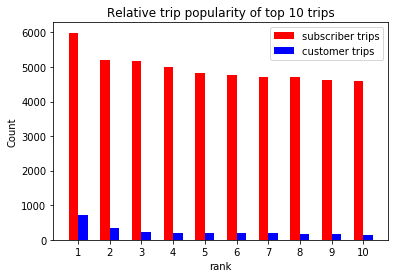

In [71]:
_x = np.arange(len(top_trips.start_station_name))
fig, ax = plt.subplots()
ax.bar(_x - .15, top_trips['count'], 0.3, color='r', label="subscriber trips")
ax.bar(_x + .15, top_customer_trips['count'], 0.3, color='b', label="customer trips")
ax.set_ylabel("Count")
ax.set_xlabel("rank")
ax.set_xticks(_x)
ax.set_xticklabels(map(str, range(1,11)), ha='center')
ax.set_title("Relative trip popularity of top 10 trips")
ax.legend()
plt.show()

In the above plot we observe the top 10 trips made by subscribers and customers, and their individual counts.

### What are your recommendations for offers?

To make reasonable recommendation, we must first understand the revenue steam generated as a result of the rides made by each subscriber type. Based on the pricing page on [BayWheels](https://www.lyft.com/bikes/bay-wheels/pricing), the customers generate revenue on a per ride basis, and subsciber generate a base revenue of \\$15 per month, \\$149 per year, \\$5 per year, \\$10 per day based on their subscription plan.

Given our limited data without user information, estimation will be of limited use. However, we can calculate on average how much revenue each customer is generating per ride, and on average how much the subscribers are generating per ride in addition to their flat fees. Depending on what membership these subscribers have (monthly, annual, bikeshare for all, access pass), the true revenue generated per subscriber can vary greatly. We also assume that BayWheels generate more revenue on average on their subscribers.

In [23]:
%%bigquery revenue
SELECT subscriber_type,
       AVG(single_ride_revenue) as single_ride_revenue,
       AVG(additional_member_revenue) as additional_member_revenue
FROM
(
SELECT subscriber_type,
      CASE
           WHEN subscriber_type = "Customer" AND duration_sec > (30 * 60) THEN 2 + 3*((duration_sec - 30*60) / (15 * 60))
           WHEN subscriber_type = "Customer" AND duration_sec <= (30 * 60) THEN 2
           ELSE NULL
           END AS single_ride_revenue,
      CASE
           WHEN subscriber_type = "Subscriber" AND duration_sec > (45 * 60) THEN 3*((duration_sec - 45* 60) / (15 * 60))
           WHEN subscriber_type = "Subscriber" AND duration_sec <= (45 * 60) THEN 0
           ELSE NULL
           END AS additional_member_revenue
FROM `practical-net-263804.bike_trip_data.initial`
)
GROUP BY subscriber_type

In [24]:
revenue

,subscriber_type,single_ride_revenue,additional_member_revenue
0,Customer,7.546834,NaN
1,Subscriber,NaN,0.07739


We see that the customers generate on average \\$7.55 per ride, whereas usual members generate only \\$0.07 per ride. This tell us very little about the true revenue generated by subscribers, but gives a true average of the revenue generated per ride for customers. In general adjusting pricing should be a last resort as it either reduce our revenue, or drives away users. Without further investigation with more data and user information, pricing adjustment will more likely lead to these situations. Nonetheless, it gives us a good sense of how much revenue is generated.

Another direction to tackle this problem can be found in the other table bikeshare table `bigquery-public-data.san_francisco.bikeshare_status`, which has records of the number of bikes available at each station overtime. With the following query we find the stations that are most often empty during commute hours.

In [7]:
%%bigquery empty

SELECT station_id, COUNT(station_id) as count
FROM `bigquery-public-data.san_francisco.bikeshare_status`
WHERE bikes_available = 0 AND ( (EXTRACT(HOUR from time) >= 6 AND EXTRACT(HOUR from time) <= 9) or
      (EXTRACT(HOUR from time) >= 16 AND EXTRACT(HOUR from time) <= 20) ) AND docks_available > 0
GROUP BY station_id
ORDER BY count DESC

In [8]:
empty.head(10)

,station_id,count
0,62,24832
1,45,24396
2,48,23817
3,82,21357
4,60,20779
5,70,18213
6,73,17215
7,41,17086
8,64,16326
9,65,14891


Of these most often empty bike stations, we can identify those that are most often used with a `JOIN` query on our initial query.

In [12]:
%%bigquery empty_most_used

SELECT subscriber_type, station_id, start_station_name, COUNT(*) as count_trips
FROM `practical-net-263804.bike_trip_data.initial` initial
JOIN `practical-net-263804.bike_trip_data.often_empty` often_empty
ON initial.start_station_id = often_empty.station_id
GROUP BY subscriber_type, start_station_name, station_id
ORDER BY count_trips DESC
LIMIT 10

In [13]:
empty_most_used

,subscriber_type,station_id,start_station_name,count_trips
0,Subscriber,70,San Francisco Caltrain (Townsend at 4th),68371
1,Subscriber,69,San Francisco Caltrain 2 (330 Townsend),53687
2,Subscriber,55,Temporary Transbay Terminal (Howard at Beale),37886
3,Subscriber,50,Harry Bridges Plaza (Ferry Building),36612
4,Subscriber,61,2nd at Townsend,35492
5,Subscriber,74,Steuart at Market,34056
6,Subscriber,65,Townsend at 7th,32780
7,Subscriber,77,Market at Sansome,31261
8,Subscriber,60,Embarcadero at Sansome,27195
9,Subscriber,67,Market at 10th,26556


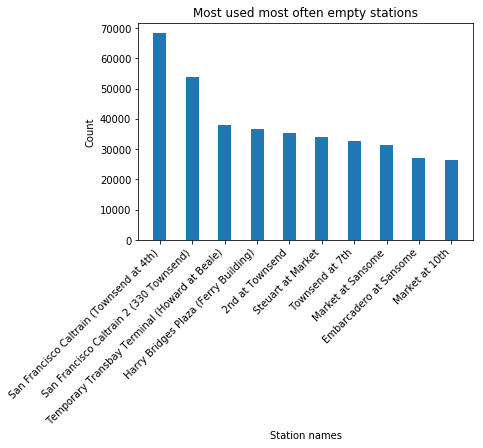

In [16]:
_x = np.arange(len(empty_most_used.start_station_name))
fig, ax = plt.subplots()
ax.bar(_x, empty_most_used.count_trips, 0.4)
ax.set_ylabel("Count")
ax.set_xlabel("Station names")
ax.set_xticks(_x)
ax.set_xticklabels(empty_most_used.start_station_name, rotation=45, ha='right')
ax.set_title("Most used most often empty stations")
plt.show()

In the above bar chart we identify the top 10 most often empty stations that are also most used, based on data in `bigquery-public-data.san_francisco.bikeshare_status`. If we compare this chart with the top subscriber commuter trips shown below, we observe that only Market at Sansome and Market at 10th are not trips in the top 10 popular start stations. Most likely there are times when users want to use the bikes when there are none for these stations.

In [19]:
top_trips

,subscriber_type,start_station_name,end_station_name,count
0,Subscriber,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,5990
1,Subscriber,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5199
2,Subscriber,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5171
3,Subscriber,Embarcadero at Sansome,Steuart at Market,5005
4,Subscriber,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4834
5,Subscriber,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),4767
6,Subscriber,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),4710
7,Subscriber,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4704
8,Subscriber,Steuart at Market,2nd at Townsend,4620
9,Subscriber,Steuart at Market,San Francisco Caltrain (Townsend at 4th),4589


#### The reccomendations for the offers made here is thus the following:

To divert customers who are not on their commute trips during commute hours, set up small stations close to the most popular commute start stations such as San Francisco Caltrain (Townsend at 4th) and San Francisco Caltrain 2 (330 Townsend). Offer limited time deals to some customers when they look for bikes at these start stations if they divert to using the small stations near by. Since there customers might not be on a commute trip, they are more likely to make the effort to get to these stations and receive the deals. On the other hand subscribers will have more bikes to use at the popular sations for their timely commute trips. This plan serves as a "stress releif" for high density areas during rush hours. Despite the up front cost and the reduced revenue due to deals, the service will ultimately generate more revenue when it accomodates more users.